In [1]:
import sys
import os
print(sys.path)
print()
print(os.environ['LD_LIBRARY_PATH'])

['/home/ringoshin/.Envs/pfbot/lib/python36.zip', '/home/ringoshin/.Envs/pfbot/lib/python3.6', '/home/ringoshin/.Envs/pfbot/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '', '/home/ringoshin/.Envs/pfbot/lib/python3.6/site-packages', '/home/ringoshin/.Envs/pfbot/lib/python3.6/site-packages/IPython/extensions', '/home/ringoshin/.ipython']

/usr/local/cuda-10.0/lib64


In [2]:
sys.path.append("/usr/local/cuda-10.0/bin")
print(sys.path)

#os.environ['LD_LIBRARY_PATH'] = "/usr/local/cuda-10.0/lib64

['/home/ringoshin/.Envs/pfbot/lib/python36.zip', '/home/ringoshin/.Envs/pfbot/lib/python3.6', '/home/ringoshin/.Envs/pfbot/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '', '/home/ringoshin/.Envs/pfbot/lib/python3.6/site-packages', '/home/ringoshin/.Envs/pfbot/lib/python3.6/site-packages/IPython/extensions', '/home/ringoshin/.ipython', '/usr/local/cuda-10.0/bin']


In [3]:
import tensorflow as tf
gpu_check = tf.test.gpu_device_name()
#print(tf.test.gpu_device_name(),'\n')
if 'GPU' in gpu_check:
    print("Yes, we have GPU!")
else:
    print("No GPU found.")

Yes, we have GPU!


In [4]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [1]:
pwd

'/home/ringoshin/Projects/z - learning/0 - Kaplan/proj/pfbot'

In [0]:
cd 'My Drive/data'

/gdrive/My Drive/data


In [4]:
!ls *txt

ls: cannot access '*txt': No such file or directory


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gensim
import string

import textwrap

from keras.layers import LSTM, CuDNNLSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.callbacks import LambdaCallback, ModelCheckpoint

from keras.utils.data_utils import get_file
from keras.models import load_model
import pickle

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


Using TensorFlow backend.


In [5]:
print('\nFetching the text...')
#path = 'dragonlance_chronicles.txt'
#path = 'textgen_pathfinder.txt'
path = 'data/textgen_pathfinder.txt'


Fetching the text...


In [6]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding="utf8")
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [7]:
# load document
docs = load_doc(path)
#print(docs[:200])
print(textwrap.fill('%s' % (docs[:200]), 80))

The giant black widow spider is a tough, CR 3  poisonous spider. The marsh-
dwelling lizardfolk can be dangerous enemies or helpful—if cautiously
neutral—allies. The flesh-eating minotaur is a tough so


In [8]:
# -*- coding: utf-8 -*-
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [9]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
import string
 
# turn a doc into clean tokens
def clean_doc(doc):
    # replace '--' with a space ' '
    doc = doc.replace('--', ' ')
    # replace '-' with a space ' '
    doc = doc.replace('-', ' ')
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # make lower case
    tokens = [word.lower() for word in tokens]
    return tokens

In [11]:
tokens = clean_doc(docs)
print(tokens[:200])
print('Total Tokens: %d' % len(tokens))
print('Unique Tokens: %d' % len(set(tokens)))

['the', 'giant', 'black', 'widow', 'spider', 'is', 'a', 'tough', 'cr', 'poisonous', 'spider', 'the', 'marsh', 'dwelling', 'lizardfolk', 'can', 'be', 'dangerous', 'enemies', 'or', 'cautiously', 'the', 'flesh', 'eating', 'minotaur', 'is', 'a', 'tough', 'solo', 'opponent', 'for', 'higher', 'level', 'characters', 'or', 'the', 'deadly', 'boss', 'of', 'a', 'tribe', 'of', 'orcs', 'or', 'goblins', 'the', 'wererat', 'is', 'a', 'sneaky', 'shapeshifter', 'relying', 'on', 'stealth', 'and', 'sneak', 'attacks', 'instead', 'of', 'a', 'frontal', 'assault', 'like', 'the', 'werewolf', 'the', 'entrance', 'to', 'the', 'old', 'mine', 'the', 'outside', 'of', 'the', 'mine', 'is', 'a', 'natural', 'cave', 'supported', 'by', 'thick', 'timbers', 'and', 'extending', 'straight', 'into', 'the', 'hillside', 'you', 'can', 'see', 'fragments', 'of', 'old', 'tools', 'rusted', 'mine', 'cart', 'rails', 'and', 'a', 'few', 'recent', 'dwarven', 'boot', 'prints', 'but', 'it', 'is', 'otherwise', 'quiet', 'before', 'you', 'ente

In [12]:
# organize into sequences of tokens
length = 50 + 1
sequences = list()
for i in range(length, len(tokens)):
    # select sequence of tokens
    seq = tokens[i-length:i]
    # convert into a line
    line = ' '.join(seq)
    # store
    sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 13046


In [13]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [14]:
# save sequences to file
out_filename = 'data/pathfinder_token_sequences.txt'
save_doc(sequences, out_filename)

In [14]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding="utf8")
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [15]:
# load
in_filename = 'data/pathfinder_token_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')

In [16]:
sentences = [line.split() for line in lines]
#sentences[:2]

In [ ]:
# save gensim Word2Vec word model trained with text sentences
pickle.dump(word_model, open('pathfinder_token_w2v300_word_model.pkl', 'wb'))
pickle.dump(pretrained_weights, open('pathfinder_token_w2v300_weights.pkl', 'wb'))

# save the tokenizer
pickle.dump(tokenizer, open('pathfinder_token_tokenizer.pkl', 'wb'))

# save the model to file
model.save('pathfinder_token_w2v_model_100_epoch.h5')
# with open('pathfinder_token_w2v_model_100_epoch.pkl', 'wb') as f:
#        pickle.dump(model, f)

# serialize weights to HDF5
model.save_weights("pathfinder_token_w2v_model_100_epoch_weights.h5")

# save the history
with open('pathfinder_token_w2v_model_100_epoch_history.pkl', 'wb') as f:
    pickle.dump(history, f)  

In [17]:
word_model = pickle.load(open('model/pathfinder_token_w2v300_word_model.pkl', 'rb'))
pretrained_weights = pickle.load(open('model/pathfinder_token_w2v300_weights.pkl', 'rb'))

tokenizer = pickle.load(open('model/pathfinder_token_tokenizer.pkl', 'rb'))

#model = load_model('model/pathfinder_token_w2v_model_100_epoch.h5')
#model = pickle.load(open('pathfinder_token_w2v_model_100_epoch.pkl', 'rb'))

#history = pickle.load(open('model/pathfinder_token_w2v_model_100_epoch_history.pkl', 'rb'))

#model.load_weights("model/pathfinder_token_w2v_model_100_epoch_weights.h5")

In [18]:
word_model = pickle.load(open('model/pathfinder_token_w2v300_word_model.pkl', 'rb'))
pretrained_weights = pickle.load(open('model/pathfinder_token_w2v300_weights.pkl', 'rb'))

tokenizer = pickle.load(open('model/pathfinder_token_tokenizer.pkl', 'rb'))

model = load_model('model/pathfinder_token_w2v_model_100_epoch.h5')
#model = pickle.load(open('pathfinder_token_w2v_model_100_epoch.pkl', 'rb'))

history = pickle.load(open('model/pathfinder_token_w2v_model_100_epoch_history.pkl', 'rb'))

model.load_weights("model/pathfinder_token_w2v_model_100_epoch_weights.h5")





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [18]:
pretrained_weights = word_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)

Result embedding shape: (2925, 300)


/home/ringoshin/.Envs/pfbot/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [19]:
sequences = tokenizer.texts_to_sequences(lines)

In [20]:
# define model
model = Sequential()
#model.add(Embedding(vocab_size, 100, input_length=seq_length))
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights]))

model.add(LSTM(emdedding_size, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(emdedding_size))
model.add(Dropout(0.2))

model.add(Dense(emdedding_size, activation='relu'))

model.add(Dense((vocab_size+1), activation='softmax'))
print(model.summary())











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         877500    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 300)         721200    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300 

In [21]:
model.load_weights("model/pathfinder_token_w2v_model_100_epoch_weights.h5")

In [18]:
print('\nTraining word2vec...')
# workers=1 will ensure a fully deterministrically-reproducible run, per Gensim docs
word_model = gensim.models.Word2Vec(sentences, size=300, min_count=1, window=5, iter=100, workers=1)
pretrained_weights = word_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)


Training word2vec...
Result embedding shape: (2925, 300)


/home/ringoshin/.Envs/pfbot/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


In [22]:
print('Checking similar words:')
for word in ['gold', 'goblin', 'magic', 'priest', 'mine']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))

Checking similar words:
  gold -> studded (0.31), empathize (0.26), not (0.25), communicate (0.25), here (0.24), investigating (0.23), provide (0.23), engraved (0.23)
  goblin -> warriors (0.54), reckless (0.47), tries (0.40), fights (0.36), pound (0.36), ac (0.36), acquired (0.34), accessible (0.33)
  magic -> largest (0.37), korvosan (0.36), minor (0.36), acadamae (0.34), radiate (0.33), torches (0.30), initially (0.30), identifies (0.29)
  priest -> sole (0.82), birm (0.80), curate (0.66), amelon (0.65), temple (0.54), desna (0.48), archways (0.45), sun (0.43)
  mine -> hillside (0.30), energy (0.29), movement (0.26), lowdown (0.25), second (0.23), cracked (0.22), managed (0.22), arts (0.22)


/home/ringoshin/.Envs/pfbot/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
from numpy import array
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [67]:
# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

In [24]:
# vocabulary size
#vocab_size = len(tokenizer.word_index) + 1
#print(tokenizer.word_index)
input_size=vocab_size+1

In [25]:
# separate into input and output
sequences = array(sequences)
X, y = sequences[:,:-1], sequences[:,-1]
y = to_categorical(y, num_classes=(input_size))
seq_length = X.shape[1]
print(X.shape)

(13046, 50)


In [26]:
X[:2]

array([[   1,  457,  232,  850,   86,    7,    2,  843, 1364, 2925,   86,
           1, 1363, 2924,  849,   24,   37,  848, 1362,   18, 2920,    1,
         456,  847,  599,    7,    2,  843, 2919, 2918,   19,  340,  455,
         281,   18,    1, 2917, 2916,    4,    2,  598,    4,  840,   18,
         339,    1,  596,    7,    2, 2913],
       [ 457,  232,  850,   86,    7,    2,  843, 1364, 2925,   86,    1,
        1363, 2924,  849,   24,   37,  848, 1362,   18, 2920,    1,  456,
         847,  599,    7,    2,  843, 2919, 2918,   19,  340,  455,  281,
          18,    1, 2917, 2916,    4,    2,  598,    4,  840,   18,  339,
           1,  596,    7,    2, 2913, 1365]])

In [33]:
y[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [25]:
# define model
model = Sequential()
#model.add(Embedding(vocab_size, 100, input_length=seq_length))
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights]))

model.add(CuDNNLSTM(emdedding_size, return_sequences=True))
model.add(Dropout(0.2))

model.add(CuDNNLSTM(emdedding_size))
model.add(Dropout(0.2))

model.add(Dense(emdedding_size, activation='relu'))

model.add(Dense((vocab_size+1), activation='softmax'))
print(model.summary())









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         877500    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, None, 300)         722400    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 300)               722400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300   

In [27]:
def NN_Plt_Training(history, starting_epoch=0):
    # acc = history.history['categorical_accuracy']
    acc = history.history['acc']
    loss = history.history['loss']
    
    nb_epochs = len(acc)
    starting_epoch = starting_epoch if starting_epoch < nb_epochs else 0
    epochs = range(starting_epoch, nb_epochs)

    # Plot the accuracy curves
    plt.figure(figsize=(6,6))
    plt.plot(epochs, acc[starting_epoch:],'b', linestyle='-', label='accuracy')
    plt.plot(epochs, loss[starting_epoch:],'r', linestyle='-', label='loss')
    plt.title('Training Accuracy/Loss per Epoch')
    plt.legend()

In [28]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#metrics=['categorical_accuracy']
# fit model
#history = model.fit(X, y, batch_size=128, epochs=100)
#history = model.fit(X, y, batch_size=32, epochs=50)
history = model.fit(X, y, batch_size=8, epochs=50)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50


UnknownError: 2 root error(s) found.
  (0) Unknown: Fail to find the dnn implementation.
	 [[{{node cu_dnnlstm_1/CudnnRNN}}]]
	 [[metrics/acc/Mean/_143]]
  (1) Unknown: Fail to find the dnn implementation.
	 [[{{node cu_dnnlstm_1/CudnnRNN}}]]
0 successful operations.
0 derived errors ignored.

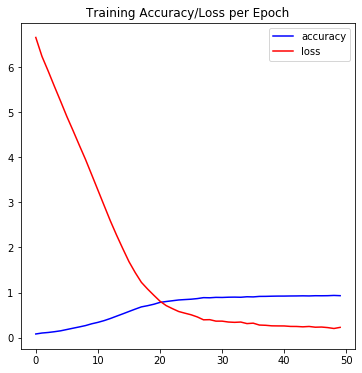

In [33]:
# plot training accuracy/loss chart
NN_Plt_Training(history)

In [35]:
# save the model to file
model.save('model/pathfinder_token_w2v_model_100_epoch.h5')
# save the history
with open('model/pathfinder_token_w2v_model_100_epoch_history.pkl', 'wb') as f:
    pickle.dump(history, f)  
# save the tokenizer
dump(tokenizer, open('model/pathfinder_token_tokenizer.pkl', 'wb'))

In [27]:
from random import randint
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

In [28]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding="utf8")
    # read all text
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [29]:
def sample_word(preds, temperature=1.0):
    if temperature <= 0:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [30]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words, temperature=0):
    result = list()
    in_text = seed_text
    # generate a fixed number of words
    for _ in range(n_words):
        # encode the text as integer
        #   [0] coz shape is (num_lines, num_tokens_per_line)
        #   and there is only one line right now
        #   also num_tokens is not a const, hence trunc will be required
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        # truncate sequences to a fixed lenght
        encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
        # predict probabilities for each word
        #yhat = model.predict_classes(encoded, verbose=0)
        yhat = sample_word(model.predict(encoded,verbose=0)[-1], temperature)
        # map predicted word index to word
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        # append to input
        in_text += ' ' + out_word
        result.append(out_word)
    return ' '.join(result)

In [31]:
# load cleaned text sequences
in_filename = 'data/pathfinder_token_sequences.txt'
doc = load_doc(in_filename)
lines = doc.split('\n')
seq_length = len(lines[0].split()) - 1

In [26]:
# load the model
#model = load_model('pathfinder_token_model_300_epoch.h5')
#model = load_model('pathfinder_token_model_250_epoch.h5')
#model = load_model('pathfinder_token_model_150_epoch.h5')
#model = load_model('pathfinder_token_model_200_epoch.h5')
model = load_model('model/pathfinder_token_w2v_model_100_epoch.h5')


W1013 18:11:26.298218 140691208886080 deprecation_wrapper.py:119] From /home/ringoshin/anaconda3/envs/tensorflow-gpu-nlp/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1013 18:11:26.302481 140691208886080 deprecation_wrapper.py:119] From /home/ringoshin/anaconda3/envs/tensorflow-gpu-nlp/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1013 18:11:26.993060 140691208886080 deprecation_wrapper.py:119] From /home/ringoshin/anaconda3/envs/tensorflow-gpu-nlp/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1013 18:11:26.994733 140691208886080 deprecation_wrapper.py:119] From /home/ringoshin/anaconda3/envs/tensorflow-gpu-nlp/lib/python3.7/site-packages/keras/backend/ten

In [48]:
# load the tokenizer
tokenizer = pickle.load(open('model/pathfinder_token_tokenizer.pkl', 'rb'))

In [32]:
len(lines)
lines[:5]

['the giant black widow spider is a tough cr poisonous spider the marsh dwelling lizardfolk can be dangerous enemies or cautiously the flesh eating minotaur is a tough solo opponent for higher level characters or the deadly boss of a tribe of orcs or goblins the wererat is a sneaky shapeshifter',
 'giant black widow spider is a tough cr poisonous spider the marsh dwelling lizardfolk can be dangerous enemies or cautiously the flesh eating minotaur is a tough solo opponent for higher level characters or the deadly boss of a tribe of orcs or goblins the wererat is a sneaky shapeshifter relying',
 'black widow spider is a tough cr poisonous spider the marsh dwelling lizardfolk can be dangerous enemies or cautiously the flesh eating minotaur is a tough solo opponent for higher level characters or the deadly boss of a tribe of orcs or goblins the wererat is a sneaky shapeshifter relying on',
 'widow spider is a tough cr poisonous spider the marsh dwelling lizardfolk can be dangerous enemies 

In [46]:
# select a seed text
seed_text = lines[randint(0,len(lines))]
print(textwrap.fill('%s' % (seed_text), 80) + '\n')

their thick webs to slow and capture foes before cocooning and devouring them
lizardfolk are proud and powerful reptilian predators that live in swamps
marshes and coasts they reject civilization and prefer simple tribal life in
their own lands they are known to eat their dead enemies and allies whenever a



In [34]:
seed_text='monk who lives in the abbey'

In [47]:
# generate new text
generated = generate_seq(model, tokenizer, seq_length, seed_text, 50, 1.5)
print(textwrap.fill('%s' % (generated), 80))

/home/ringoshin/.Envs/pfbot/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


giant black widow spider bites a foe that creature must make a fortitude saving
throw as if hork on the stealth sailor points of the demos can make its own
preparations that area but all below needs to be discrete alive to see them in
other sensitive tauranor ended the


In [50]:
special_gen="""few weeks ago and have not yet returned the three missing monks are piotr oja
ollie lenstraand tibaldo russo brother joachim informs the pcs there is a cave
that has been used for shelter in the mountains along the route to galduria and
describes how the pcs can locate it as the pcs travel further north they can see
and feel approach small patches of snow linger in shaded areas the grasses are a
dull"""

In [51]:
generated = special_gen
print(textwrap.fill('%s' % (generated), 80))

few weeks ago and have not yet returned the three missing monks are piotr oja
ollie lenstraand tibaldo russo brother joachim informs the pcs there is a cave
that has been used for shelter in the mountains along the route to galduria and
describes how the pcs can locate it as the pcs travel further north they can see
and feel approach small patches of snow linger in shaded areas the grasses are a
dull


In [52]:
#!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 4.4MB/s eta 0:00:011     |████▋                           | 119.2MB 15.9MB/s eta 0:00:45     |██████████████████████▌         | 583.1MB 12.9MB/s eta 0:00:20��████████████████████▋  | 765.6MB 3.5MB/s eta 0:00:188.7MB 411kB/s eta 0:00:47
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.0-cp36-none-any.whl size=829187831 sha256=3eb00e7d1388e1f5c916f404869c57edebd6d4f6378d8e0b2e8a56cee09cdf8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-7aghsh1f/wheels/9f/3c/d6/3ade7ed8195030f4d7f299cf73d856a84d7b3effd5890133fb
Successfully built en-core-web-lg
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [53]:
import spacy
from spacy import displacy
from collections import Counter
#import en_core_web_sm
#nlp = en_core_web_sm.load()
import en_core_web_lg
nlp = en_core_web_lg.load()

In [54]:
sentence_nlp = nlp(generated)

# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[]


/usr/lib/python3.6/runpy.py:193: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  "__main__", mod_spec)


In [55]:
#[(x.orth_,x.pos_, x.lemma_) for x in [y 
#                                      for y
#                                      in nlp(generated)
#                                      if (not y.is_stop and y.pos_ != 'PUNCT') or y.pos_ == 'NUM']]
noun_list = []
for token in nlp(generated):
#    if (not token.is_stop and token.pos_ != 'PUNCT') or token.pos_ == 'NUM':
    if (token.pos_ == 'NOUN'):
        noun_list.append(token)
        print((token.orth_,token.pos_, token.lemma_))

('apex', 'NOUN', 'apex')
('business', 'NOUN', 'business')
('room', 'NOUN', 'room')
('initiative', 'NOUN', 'initiative')
('journey', 'NOUN', 'journey')
('ship', 'NOUN', 'ship')
('encounter', 'NOUN', 'encounter')
('spell', 'NOUN', 'spell')
('darkvision', 'NOUN', 'darkvision')
('silver', 'NOUN', 'silver')
('tauranor', 'NOUN', 'tauranor')


In [56]:
#print([(i, noun) for i, noun in enumerate(noun_list)])
#print(doc[7], doc[8], doc[7].similarity(doc[8]))
test_doc = nlp('cave shelter mountains snow brother')
print(test_doc[0], test_doc[1], test_doc[0].similarity(test_doc[1]))
print(test_doc[0], test_doc[2], test_doc[0].similarity(test_doc[2]))
print(test_doc[1], test_doc[2], test_doc[1].similarity(test_doc[2]))
print(test_doc[2], test_doc[3], test_doc[2].similarity(test_doc[3]))
print(test_doc[0], test_doc[4], test_doc[0].similarity(test_doc[4]))

cave shelter 0.3689129
cave mountains 0.5231152
shelter mountains 0.3393006
mountains snow 0.5963584
cave brother 0.22205521


In [57]:
input_doc = nlp('wishsong abbey').similarity(nlp(lines[140]))
print(input_doc)

0.20518590843756673


In [58]:
lines[140]

'monsters and the missing dwarves fought here when the pcs enter this area draw it on the map and read the following to them the rusty mine cart rails crisscross the floor in this area leading west north east and back south to the entrance dwarven boot prints are visible all'

In [59]:
vocab_dict = word_model.wv.vocab

In [60]:
vocab = [k for k in vocab_dict.keys()]

In [61]:
len(vocab)

2925

In [0]:
import gensim.downloader as api
wv_glove = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
for word in ['gold', 'goblin', 'magic', 'priest', 'mine']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in wv_glove.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))

In [0]:
for word in ['zimandi', 'goblin', 'magic', 'priest', 'mine']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))

In [0]:
not_found_list, name_list, oov_list = [], [], []
skip_words = ['darkvision', 'bracers', 'dungeoneering', 'ungracefully', 'lycanthropic', 'starknife' ]
for word,i in word_model.wv.vocab.items():
    try:
        embedding_vector = wv_glove.wv[word] 
    except:
        not_found_list.append(word)
        if word not in skip_words:
            name_list.append(word)
        else:
            oov_list.append(word)
        #print(word, 'not found')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [0]:
name_list

['wererat',
 'grald',
 'mapand',
 'wererats',
 'erastil',
 'eberius',
 'tauranor',
 'aroden',
 'azlanti',
 'golarion',
 'varisian',
 'varisia',
 'thassilonian',
 'runelord',
 'rockwhelp',
 'lurkwood',
 'xanderghul',
 'heidmarch',
 'thassilon',
 'runelords',
 'riddleport',
 'yarg',
 'hork',
 'shalesmash',
 'galduria',
 'amelon',
 'birm',
 'hazelindra',
 'acadamae',
 'montrovale',
 'korvosa',
 'academae',
 'gorbic',
 'korvosan',
 'zamola',
 'duso',
 'galino',
 'magnimar',
 'tibaldo',
 'lenstraand',
 'aldemar',
 'jargie',
 'elliana',
 'sarenrae',
 'neergah',
 'versade',
 'savasha',
 'magnimarian',
 'deverin',
 'irespan',
 'dockway',
 'nindrik',
 'gradon',
 'scarnetti',
 'cheiskaia',
 'nirodin',
 'zimandi',
 'kaddren',
 'tauk',
 'grapnel',
 'farthough',
 'zorakov',
 'kantaro',
 'korvut',
 'zanthus',
 'brinestump',
 'kavoos',
 'belor']

In [0]:
doc = nlp(generated)
for chunk in doc.noun_chunks:
    print("{} | {} | {} | {}".format(chunk.text, chunk.root.text, chunk.root.dep_,
            chunk.root.head.text))

the three missing monks | monks | dobj | returned
oja
ollie lenstraand tibaldo | tibaldo | ROOT | tibaldo
russo brother joachim | joachim | nsubj | informs
the pcs | pcs | dobj | informs
a cave | cave | attr | is
shelter | shelter | pobj | for
the mountains | mountains | pobj | in
the route | route | pobj | along
galduria | galduria | pobj | to
the pcs | pcs | nsubj | locate
it | it | dobj | locate
pcs | pcs | nsubj | travel
they | they | nsubj | see
small patches | patches | nsubj | linger
snow | snow | pobj | of
shaded areas | areas | pobj | in
the grasses | grasses | nsubj | are


In [0]:
import spacy
from spacy.tokens import Span

nlp = spacy.load("en_core_web_sm")
doc = nlp(u"FB is hiring a new Vice President of global policy")
ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
print('Before', ents)
# the model didn't recognise "FB" as an entity :(

MOG = doc.vocab.strings[u"MOG"]  # get hash value of entity label
ORG = doc.vocab.strings[u"ORG"]  # get hash value of entity label
fb_ent = Span(doc, 0, 1, label=ORG) # create a Span for the new entity
doc.ents = list(doc.ents) + [fb_ent]

ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
print('After', ents)
# [(u'FB', 0, 2, 'MOG')]

Before []
After [('FB', 0, 2, 'ORG')]


In [0]:
(MOG, ORG)

(1030335124240825175, 383)

In [0]:
displacy.render(doc, style='ent', jupyter=True)

In [0]:
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import sys
from time import time

import numpy as np

In [0]:
n_clusters = 300
n_components = 300  # Preprocess documents with latent semantic analysis, 0 means not using LSA.
n_features=vocab_size+1    # Maximum number of features (dimensions) to extract from text

minibatch=True     # Use minibatch vs ordinary k-means algorithm
use_idf=True       # Enable Inverse Document Frequency feature weighting
use_hashing=False  # Use a hashing feature vectorizer"
verbose=False      # Print progress reports inside k-means algorithm

In [0]:
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if use_hashing:
    if use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=n_features,
                                   stop_words='english', 
                                   # non_negative=True,
                                   norm=None, binary=False)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=n_features,
                                       stop_words='english',
                                       # non_negative=False, 
                                       norm='l2',
                                       binary=False)
else:
    vectorizer = TfidfVectorizer(max_df=1.0, max_features=n_features,
                                 min_df=1, stop_words='english',
                                 use_idf=use_idf)
X = vectorizer.fit_transform(lines)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()

Extracting features from the training dataset using a sparse vectorizer
done in 0.395989s
n_samples: 13046, n_features: 2695

Performing dimensionality reduction using LSA
done in 3.075784s
Explained variance of the SVD step: 87%



In [0]:
svd.explained_variance_ratio_

array([0.0032464 , 0.01107117, 0.01028093, 0.00942792, 0.00832555,
       0.00813238, 0.00790249, 0.00763405, 0.00758528, 0.00730429,
       0.00718659, 0.0070021 , 0.00667041, 0.0065344 , 0.00643486,
       0.00635928, 0.00612863, 0.00601874, 0.00598221, 0.00584826,
       0.00577443, 0.00570543, 0.0056314 , 0.00558886, 0.00550061,
       0.00547608, 0.00539681, 0.00535817, 0.00527654, 0.00521335,
       0.00516126, 0.00506738, 0.00502929, 0.00496283, 0.00494132,
       0.00487899, 0.00483955, 0.00480248, 0.004764  , 0.0047417 ,
       0.00466875, 0.00464345, 0.00462921, 0.00460841, 0.00454388,
       0.00451306, 0.00449327, 0.00448734, 0.00442228, 0.00441111,
       0.00433001, 0.00431588, 0.00430321, 0.00427256, 0.00425866,
       0.00423261, 0.004201  , 0.00415912, 0.0041197 , 0.00410485,
       0.00406614, 0.00404558, 0.00403571, 0.00398393, 0.00396482,
       0.00396137, 0.00391653, 0.00391202, 0.00389419, 0.00388173,
       0.0038626 , 0.0038509 , 0.00382029, 0.00380402, 0.00377

In [0]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print(", ".join(["{:.3f}".format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [0]:
display_topics(svd, vectorizer.get_feature_names(), 15)


Topic  0
pcs, pc, check, area, dc, round, make, surprised, perception, surprise, elemental, spider, combat, captain, sandpoint
0.334, 0.196, 0.196, 0.192, 0.179, 0.132, 0.126, 0.125, 0.117, 0.111, 0.111, 0.104, 0.100, 0.096, 0.087

Topic  1
surprised, round, surprise, combat, elemental, action, spider, hork, initiative, standard, actions, normal, yarg, mother, act
0.416, 0.379, 0.372, 0.241, 0.184, 0.170, 0.166, 0.112, 0.091, 0.088, 0.085, 0.070, 0.065, 0.064, 0.052

Topic  2
area, prints, enter, north, tunnel, dwarves, draw, dwarf, rails, cart, east, sinkhole, boot, ground, pc
0.369, 0.156, 0.123, 0.122, 0.114, 0.111, 0.110, 0.102, 0.102, 0.102, 0.097, 0.093, 0.090, 0.088, 0.084

Topic  3
check, dc, pc, successful, knowledge, damage, spell, character, save, perception, make, envoy, scepter, climb, device
0.276, 0.276, 0.204, 0.130, 0.118, 0.116, 0.107, 0.096, 0.093, 0.091, 0.090, 0.084, 0.068, 0.064, 0.062

Topic  4
damage, spell, ring, bonus, use, points, action, creature, armor, sa

In [0]:
if minibatch:
    km = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', n_init=3,
                         init_size=1000, batch_size=1000, verbose=verbose)
else:
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=10,
                verbose=verbose)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
#print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
#print("Adjusted Rand-Index: %.3f"
#      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()


if not use_hashing:
    print("Top terms per cluster:")

    if n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(n_clusters):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :15]:
            print(' %s' % terms[ind], end='')
        print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=300, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=False)
done in 2.160s

Silhouette Coefficient: 0.435

Top terms per cluster:
Cluster 0: smelling faintly macabre miscreants haze sigils discovered dumped blood strange contents drunken performing black candle
Cluster 1: barn saw shows ran dinner werewolf direction expected comfortable showing allow prepare pcs sure yordan
Cluster 2: knuckles bloody purchased roving hunt having wanderers muttering moments disappears absalom team painful information band
Cluster 3: knowledge religion candle pcs minor arcana flame deal defeated successful learn development item section extinguished
Cluster 4: fight mini dungeon unless brother encounter unconscious durn nearby confident heal hit form points draw
Cluster 5: 

In [0]:
#input_line = ['scaring farmer animals']
input_line = ['fearfully and in hiding run a farmer off his or her land so they could move in so farthough']
X_test = vectorizer.transform(input_line)
X_test = lsa.transform(X_test)
km.predict(X_test)

array([24], dtype=int32)

In [0]:
cluster_found = 'land farthough savagely fearfully mauled albeit animals hiding lycanthropes farmer farm sufficient motivation run living'
seed_text = cluster_found + ' ' + input_line[0]
seed_text

'land farthough savagely fearfully mauled albeit animals hiding lycanthropes farmer farm sufficient motivation run living tell me about the land near the farm'

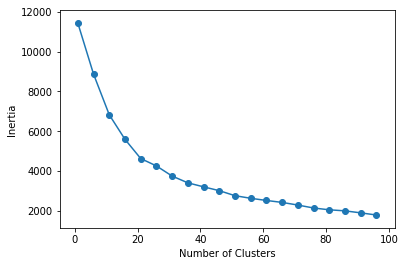

In [0]:
inertia = []
list_num_clusters = list(range(1,100, 5))
for num_clusters in list_num_clusters:
    km = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=3,
                         init_size=1000, batch_size=1000, verbose=verbose)
    # km = KMeans(n_clusters=num_clusters)
    km.fit(X)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [0]:
num_of_gen = 2000
seed_list, gen_list = [], []

for _ in range(num_of_gen):
    # select a seed text
    seed_text = lines[randint(0,len(lines))]
    # generate new text
    gen_text = generate_seq(model, tokenizer, seq_length, seed_text, 50)
    
    seed_list.append(seed_text)
    gen_list.append(gen_text)


In [0]:
skip = 1000
for row in range(3):
    actual_row = row+skip
    print('----- row {} {}'.format(actual_row, '-'*70))
    print(textwrap.fill('%s' % (seed_list[actual_row]), 80) + '\n')
    print(textwrap.fill('%s' % (gen_list[actual_row]), 80))
    print()

----- row 1000 ----------------------------------------------------------------------
secret door indicated on map as the pcs descend a narrow stairway they enter the
secret chamber rumored to hold the crosier magical flameless torches illuminate
this massive stone chamber which features a strange series of columns rising
from a deep chasm in the center the top of each column is

flush with the surface of the floor and features an arcane rune at the far end
of the room stand two stone thrones on a raised dais on the wall behind the left
throne is a relief of a king signing a document while speaking to a crowd of
featureless

----- row 1001 ----------------------------------------------------------------------
there are monsters within who can fly or climb past the sinkhole or the
earthquake opened a connection to a deeper area inhabited by underground
monsters page of the game guide to choose from experience points the pcs earn
experience points for defeating the monsters and rescuing 

In [0]:
import pandas as pd

df = pd.DataFrame({'seed': seed_list, 'generated': gen_list})
df.to_csv('pathfinder_token_w2v, csv', index=False)